Copyright (c) 2023, Douglas Santry
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, is permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense

from math import sin as sine
from statistics import mean

import numpy as np
import matplotlib.pyplot as plt


In [2]:
#
# Create the ground truth (data set)
#

x = tf.sort (tf.random.uniform ([64]) * 3.14159265359 / 2) # sort so that we can draw lines
y = np.c_[[*map (lambda u : sine (u), x)]]


Metal device set to: Apple M1


2023-12-20 15:13:29.080498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 15:13:29.080585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
sine_model = tf.keras.models.Sequential ()

sine_model.add (Dense (10, input_shape=[1], activation='sigmoid'))
sine_model.add (Dense (10, activation='sigmoid'))
sine_model.add (Dense (1, activation=None))

sine_model.build ()
sine_model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [4]:
#
# Algorithm 5.6
#

ADAM = tf.keras.optimizers.Adam ()

In [5]:
#
# Algorithm 5.3, RPROP+
#

del_0 = 1e-2
del_min = 1e-8
del_max = 50

eta_plus = 1.2
eta_minus = 0.5

del_model = []
dL_model = []

for W in sine_model.trainable_variables:
    
    del_model.append (np.full (W.shape, del_0))
    dL_model.append (np.zeros (W.shape))


def RPROP (gradients):

    for i in range (len (sine_model.trainable_variables)):

        dL = gradients[i].numpy ()

        directions = np.sign (dL * dL_model[i])
        updates = np.sign (dL)

        case1 = directions > 0
        case2 = directions < 0
        case3 = directions == 0

        # Case 1
        del_model[i][case1] = np.minimum (del_model[i][case1] * eta_plus, del_max)
        updates[case1] = -updates[case1]

        # Case 2
        del_model[i][case2] = np.maximum (del_model[i][case2] * eta_minus, del_min)

        # Case 3
        updates[case3] = -updates[case3]

        # Apply the computed update and store new state
        sine_model.trainable_variables[i].assign_add (del_model[i] * updates)
        dL_model[i] = dL
        dL_model[i][case2] = 0.0

In [6]:
#
# Equation 3.40
#
# UpdateWeights in algorithm 3.3 (line 15 omitted as not required)
#

def UpdateWeights (grad):
    
    for i in range (len (grad)):
        sine_model.trainable_variables[i].assign_add (-0.01 * grad[i])


In [7]:
#
# A training loop.  There are 3 optimizers to choose from.  Only uncomment 1 at time.
#

for epoch in range (500):
    
    with tf.GradientTape () as tape:
    
        # Note that we are not using predict.  This is a slower path that the tape
        # can monitor.
        y_ = sine_model (x, training=True)
    
        z = y_ - y
        z = z**2
    
    grad = tape.gradient (z, sine_model.trainable_variables)

    MSE = sum (z) / len (x)
    
    if epoch % 50 == 0:
        print ("Epoch %d: %f" % (epoch, MSE.numpy ()))

    if MSE < 1e-5:
        break

#
# There are 3 possible, all mutually exclusive, update strategy choices.  Only uncomment one!
#

#    RPROP (grad)
#    ADAM.apply_gradients (zip (grad, sine_model.trainable_variables))
#    UpdateWeights (grad)


Epoch 0: 0.851924
Epoch 50: 0.002540
Epoch 100: 0.000252
Epoch 150: 0.000042
Epoch 200: 0.000037
Epoch 250: 0.000035
Epoch 300: 0.000034
Epoch 350: 0.000033
Epoch 400: 0.000032
Epoch 450: 0.000031


In [8]:
#
# Our Final MSE Loss
#

MSE.numpy ()[0]

2.9312112e-05

2023-12-20 15:13:39.044862: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-20 15:13:39.082854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


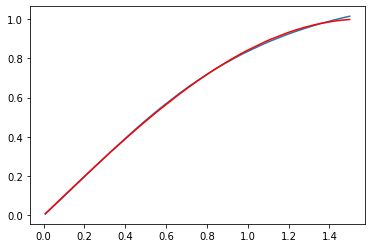

In [9]:
plt.plot (x, sine_model.predict ([x], verbose=False))
plt.plot (x, y, color="r")